# House Price Prediction with Regression and Random Forest

The aim of this project is to predict house prices using one basic machine learning algorithm, Linear Regression, and one advanced algorithm, Random Forest. We will also use regression with regularization such as Ridge and Lasso to try to improve our prediction accuracy.  

The Kaggle House Prices datasets can be downloaded [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/). 

Random Forest was found to be the better model for predicting house prices. It out performed the regession algorithms with performance accuracy of 85% using R-squared metric. The most important predictor was the overall quality of a house, following the size of above ground living area and the total basement square footage.  

This project is a first pass to get us quickly to a reasonable good model prototype.


# Import Libraries

In [32]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


#from sklearn import datasets, linear_model
#from sklearn.metrics import mean_squared_error

#from sklearn.preprocessing import PolynomialFeatures, StandardScaler, scale, MinMaxScaler
#from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
#from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, GridSearchCV
#from sklearn.ensemble import RandomForestRegressor

# Load data

In [33]:
df = pd.read_csv('USA_Housing.csv')
print(df.shape)

(5000, 7)


Our dataset has 1460 rows and 81 columns.

# Explore and clean data

In [34]:
# Peek at the dateset
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


Let's begin by looking at the features in the dataset.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


We can see some features are numeric while others are text. There are also missing values in the dataset.

In [36]:
# Find columns with missing values and their percent missing
df.isnull().sum()                                                     
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])

# Add a new column to the dataframe and fill it with the percentage of missing values
miss_val['Percent'] = miss_val.MissvalCount.apply(lambda x : '{:.2f}'.format(float(x)/df.shape[0] * 100)) 
miss_val = miss_val[miss_val.MissvalCount > 0]
miss_val

,MissvalCount,Percent


We'll remove those features with a high percent of missing values such as PoolQC, MiscFeature, Alley, Fence, and FireplaceQu. Note that the LotFrontage feature has only 16% missing. This is relatively low so we can choose to replace the NaN values with the imputed mean of the column. We will remove the remainder rows with missing values.  

In [37]:
# replace NaNs in the column with the imputed mean of that column
#df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)

In [38]:
df

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386
...,...,...,...,...,...,...,...
4995,60567.944140,7.830362,6.137356,3.46,22837.361035,1.060194e+06,USNS Williams\nFPO AP 30153-7653
4996,78491.275435,6.999135,6.576763,4.02,25616.115489,1.482618e+06,"PSC 9258, Box 8489\nAPO AA 42991-3352"
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06,"4215 Tracy Garden Suite 076\nJoshualand, VA 01..."
4998,68001.331235,5.534388,7.130144,5.44,42625.620156,1.198657e+06,USS Wallace\nFPO AE 73316


In [40]:
# drop columns with high missing values
df = df.drop(['Address'], axis=1)

In [41]:
df


,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05
...,...,...,...,...,...,...
4995,60567.944140,7.830362,6.137356,3.46,22837.361035,1.060194e+06
4996,78491.275435,6.999135,6.576763,4.02,25616.115489,1.482618e+06
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06
4998,68001.331235,5.534388,7.130144,5.44,42625.620156,1.198657e+06


In [42]:
# drop rows with any missing values
df.dropna(inplace=True)

In [43]:
#df.info()

In [44]:
# Check the dimension of the dataset
df.shape

(5000, 6)

The dataset is cleaned. It now has 1094 observations and 76 features. 

# Explore data

Let's examine the data distributions of the features. We will start with the target variable, SalesPrice, to make sure it's normal distributed. This is important because most machine learning algorithms make the assumption that the data is normal distributed. When data fits a normal distribution, we can make statements about the population using analytical techniques. 

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

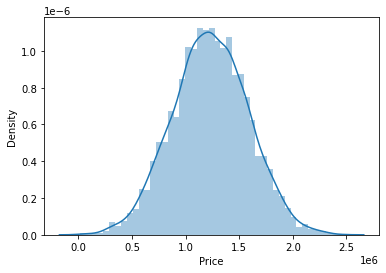

In [46]:
# Check distribution of target variable
sns.distplot(df.Price)

We can see the SalePrice distribution is skewed to the right. Let's transform it so that it follows a gaussian normal distribution.

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

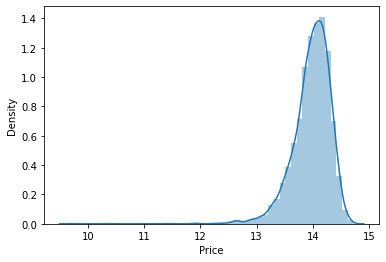

In [48]:
# Transform the target variable 
sns.distplot(np.log(df.Price))

The data is now more normal distributed. We will use this transformed data in the dataframe and remove the skewed distribution:

In [51]:
df['LogOfPrice'] = np.log(df.Price)
df.drop(["Price"], axis=1, inplace=True)

Let's check the skewness of the input feature.

In [52]:
# Review the skewness of each feature
df.skew().sort_values(ascending=False)

Avg. Area Number of Bedrooms    0.376240
Area Population                 0.050650
Avg. Area House Age            -0.007214
Avg. Area Income               -0.033720
Avg. Area Number of Rooms      -0.040996
LogOfPrice                     -1.783133
dtype: float64

Values closer to zero are less skewed. The results show some features having a positive (right-tailed) or negative (left-tailed) skew. We can see YearBuilt is slightly skewed to the left but pretty much normal distributed while LotArea and PoolArea are highly skewed to the right. Highly skewed distributions in the dataset may benefit from data transforms in some way to improve our prediction accuracy.

# Train-Test Split dataset

Before we can start modeling the data, we need to split the dataset into training and test sets. We will train the models with the training set and cross-validate with the test set. Recall we have lots of features in the dataset that are text. Most machine learning models require numerical input features. Since the process of converting text features to a numeric representation an involved task, we will only use the numeric features in our price prediction (for simplicity sake). 

In [53]:
# set the target and predictors
y = df.LogOfPrice  # target

# use only those input features with numeric data type 
df_temp = df.select_dtypes(include=["int64","float64"]) 
X = df_temp.drop(["LogOfPrice"],axis=1)  # predictors

To split the dataset, we will use random sampling with 75/25 train-test split; that is, we'll use 75% of the dataset for training and set aside 25% for testing:

In [54]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 3)

# Modeling

We will build four models and evaluate their performances with R-squared metric. Additionally, we will gain insights on the features that are strong predictors of house prices.

## Linear Regression

In [55]:
lr = LinearRegression()
# fit optimal linear regression line on training data, this performs gradient descent under the hood
lr.fit(X_train, y_train)

LinearRegression()

In [56]:
# given our model and our fit, predict y_values using X_test set
yr_hat = lr.predict(X_test)

In [57]:
# evaluate the algorithm with a test set 
lr_score = lr.score(X_test, y_test)  # train test 
print("Accuracy: ", lr_score)

Accuracy:  0.793483215220935


Let's see how well the train-test split method performed. We will do cross-validation to see whether the model is over-fitting the data:

In [58]:
# cross validation to find 'validate' score across multiple samples, automatically does Kfold stratifying
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring= 'r2')
print("Cross-validation results: ", lr_cv)
print("R2: ", lr_cv.mean())

Cross-validation results:  [0.85279191 0.79562445 0.86010487 0.80630166 0.86665044]
R2:  0.8362946651011722


It doesn't appear that for this train-test dataset, the model is not over-fitting the data (the cross-validation performance is very close in value). It may be a slightly over-fitted but we can't really tell by the R-squared metric alone. If it is over-fitted, we can do some data transforms or feature engineering to improve its performance. But our main objective initially is to spot-check a few algorithms and fine tune the model later on. 

To help prevent over-fitting in which may result from simple linear regression, we can use regression models with regularization. Let's look at ridge and lasso next.

## Regularization

The alpha parameter in ridge and lasso regularizes the regression model. The regression algorithms with regularization differ from linear regression in that they try to penalize those features that are not significant in our prediction. Ridge will try to reduce their effects (i.e., shrink their coeffients) in order to optimize all the input features. Lasso will try to remove the not-significant features by making their coefficients zero. In short, Lasso (L1 regularization) can eliminate the not-significant features, thus performing feature selection while Ridge (L2 regularization) cannot.   

## Ridge Regression

In [59]:
ridge = Ridge(alpha = 1)  # sets alpha to a default value as baseline  
ridge.fit(X_train, y_train)

ridge_cv = cross_val_score(ridge, X, y, cv = 5, scoring = 'r2')
print ("Cross-validation results: ", ridge_cv)
print ("R2: ", ridge_cv.mean())

Cross-validation results:  [0.8527974  0.79561952 0.86010925 0.80629605 0.86665421]
R2:  0.8362952874853763


## Lasso Regression

In [60]:
lasso = Lasso(alpha = .001)  # sets alpha to almost zero as baseline
lasso.fit(X_train, y_train)

lasso_cv = cross_val_score(lasso, X, y, cv = 5, scoring = 'r2')
print ("Cross-validation results: ", lasso_cv)
print ("R2: ", lasso_cv.mean())

Cross-validation results:  [0.85301771 0.79544501 0.86030039 0.80604759 0.86667928]
R2:  0.8362979951676011


Note: Alpha is the regularization parameter. The alpha values choosen for ridge and lasso serve as a starting point and are not likely the best. To determine the best alpha for the model, we can use GridSearch. We would feed GridSearch a range of alpha values and it will try them all in cross-validation to output the best one for the model.

## Random Forest

In [61]:
#rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print("R2: ", rfr_cv.mean())

R2:  0.843851776355074


Random forest is an advanced decision tree based machine learning. It has a classification and a regression random forest algorithm. Its performance is slightly better than regression. Like regularization, we can optimize the model parameters for best performance using gridsearch.

In [62]:
# Random forest determined feature importances
rfr.feature_importances_

array([0.43665595, 0.2273253 , 0.13774815, 0.01837501, 0.17989559])

# Plotting the Feature Importance
Let's see the features that are the most promissing predictors:

In [63]:
importance = rfr.feature_importances_

# map feature importance values to the features
feature_importances = zip(importance, X.columns)
#list(feature_importances)

sorted_feature_importances = sorted(feature_importances, reverse = True)
#print(sorted_feature_importances)

top_15_predictors = sorted_feature_importances[0:15]
values = [value for value, predictors in top_15_predictors]
predictors = [predictors for value, predictors in top_15_predictors]
print(predictors)

['Avg. Area Income', 'Avg. Area House Age', 'Area Population', 'Avg. Area Number of Rooms', 'Avg. Area Number of Bedrooms']


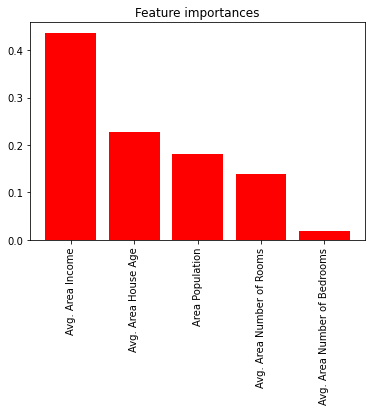

In [64]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

# Conclusion

Random Forest is the most accurate model for predicting the house price. It scored an estimated accuracy of 85%, out performing the regression models (linear, ridge, and lasso) by about 2%. Random Forest determined the overall quality of a home is by far the most important predictor. Following are the size of above grade (ground) living area and the size of total basement square footage. Surprisingly, the lot area did not rank as high as I had expected.  

Machinel learning is an iterative process. This first round of data exploration and model evaluation served as a good start to quickly gain insights to get a first reasonably good model prototype. There is a lot of structure in this dataset and further work is required to build a high performing prediction model.

Future research:  

**Data preprocessing.**Try different types of data transfoms to expose the data structure better, so we may be able to improve model accuracy
- Feature selection and removing the most correlated features (multicolinearity)
- Rescaling or normalizing the training dataset to reduce the effects of differing scales
- Standardizing the training set to reduce the effects of differing distributions
- Feature engineering to expose underlying data structures
- Binning of data (this can help improve accuracy for decision tree algorithms)    

**Modeling.**Try GridSearch to identify optimal parameters. Also, try other models and fine tune the models with ensembles

In [66]:
rfr.score(X_train,y_train)

0.9798469442392885